First, we start the analysis with investigating the correlations. We use the modal split for the use of personal cars, bus or coach, railway and tram or metro against all other variables collected from the European Commission Statistical Pocketbook 2023.

Gathering all the constructed dataframes into 1 dataset and calculating the correlations yields:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [7]:
# Read the created df-s

general_all = pd.read_csv('general_all.csv')
transport_all = pd.read_csv('transport_all.csv')
infrastructure_all = pd.read_csv('generainfrastructure_alll_all.csv')
means_transp_all = pd.read_csv('means_transp_all.csv')
modal_split = pd.read_csv('modal_split.csv')
modal_split_proz = pd.read_csv('modal_split_proz.csv')

# Merge all (except percentage modal split, will not be using it for now)
all_var = [general_all, transport_all, infrastructure_all, means_transp_all, modal_split]

# Set indexes back:
for df in all_var:
    df.set_index('Unnamed: 0', inplace=True)

# Compile
pocketbook_all = pd.concat(all_var, axis=1)
# Drop EU values
pocketbook_all = pocketbook_all.drop("EU27")
# Drop countries that do not have modal split
mod_split_var = ['cars', 'bus_coach', 'railways', 'tram_metro']
pocketbook_all = pocketbook_all.dropna(subset=mod_split_var, how='all')

pocketbook_all.head()

,Area,Population,PopDensity,indust_growth,empl_rate,GVA_agriculture,GVA_industry,GVA_services,emplshare_agriculture,emplshare_industry,...,len_motorway,len_total_road,len_rail,len_oil,stock_cars,stock_busses,cars,bus_coach,railways,tram_metro
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
BE,30.667,11.617623,0.378831,16.8,65.3,0.744217,22.020209,77.235573,1.216652,12.505261,...,1763.0,155210.0,3612.0,294.0,5927.912,16.628,96.748052,9.275137,6.969,0.945909
BG,110.996,6.838937,0.061614,10.1,68.1,4.991975,23.829727,71.178298,16.172461,35.841904,...,806.0,19925.0,4031.0,570.0,2830.464,17.731,52.013458,4.950000,1.203,0.750000
CZ,78.871,10.516707,0.133341,6.6,74.4,2.030840,33.307420,64.661740,2.994761,31.283632,...,1346.0,130757.0,9523.0,631.0,6088.730,20.555,87.933000,9.094300,6.752,3.613900
DK,42.925,5.873420,0.136830,8.3,75.5,0.998090,22.236350,76.765560,2.189251,12.756625,...,1355.0,74896.0,2485.0,330.0,2787.553,11.923,58.910000,4.834000,4.181,0.331000
DE,357.569,83.237124,0.232786,4.7,75.6,0.940321,29.552315,69.507363,1.247221,19.212984,...,13155.0,229601.0,39799.0,2370.0,48540.878,80.225,791.200000,34.300000,57.518,11.200000


Text(0.5, 1.0, 'Correlation Heatmap: EU modal split of transport')

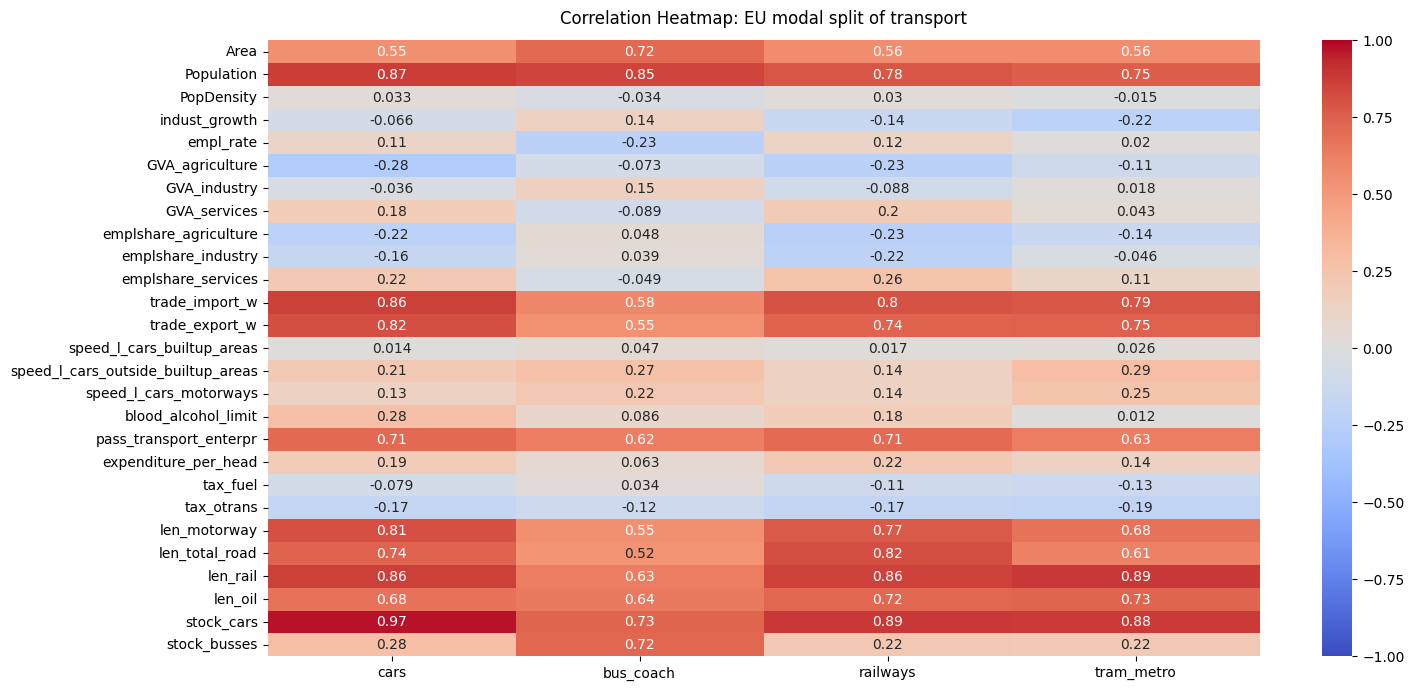

In [8]:
# prepare the correlations data
correlations = pocketbook_all.corr()
# cut out only needed values for better readability
correlations = correlations.drop(mod_split_var)
correlations = correlations[mod_split_var]

# Now creating the heatmap:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 8))
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(correlations, vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap: EU modal split of transport', fontdict={'fontsize':12}, pad=12)

Inferred information from the heatmap:

First of all, we can look into the negative correlations, as they aren't that many. The larger absolute values (or the bluest spots on the heatmap) are in its big part connected to agriculture and industrial variables. Gross value added for the agriculture sector, as well as the employment in agriculture are negatively correlated with the use of cars and railways.

When it comes to positive correlations, there are a lot of variables, that are positively correlated to the modal split as a whole. These are variables like Area, Population, Trade imports and exports, the amount of transport enterprizes and the length of differrent types of roads and even oil pipelines. This is all logical, as bigger countries with larger amounts of travel also have bigger industries, more roads etc. The biggest correlation in the dataset is at 0.97, which is the correlation between the amount of cars in a country and the modal split of car travel. It is expected, but it is another proof that the more cars are bought and in use, the governments can expect them to be used and car travel will go up with every registered car.

What would be a further point of interest ´here though, would be to test the variance between the correlation rows, as it will show which factors are better indicators of differentiating modal split. Calculating that yields:


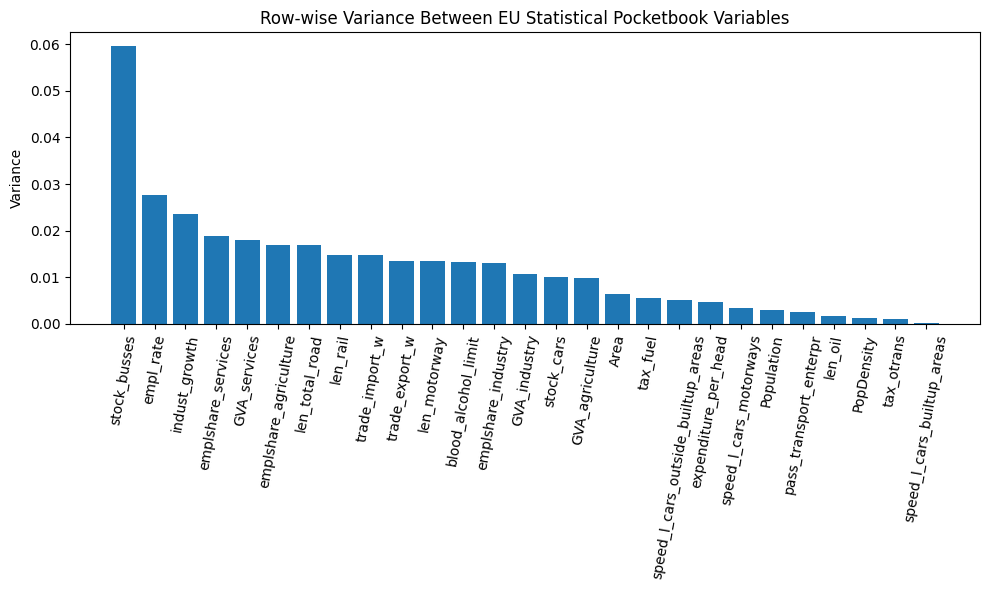

In [9]:
# Compute the row-wise variance
row_variances = correlations.var(axis=1)
row_variances = row_variances.sort_values(ascending=False)


# Create a bar plot to visualize the variances
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(row_variances.index, row_variances)
plt.ylabel('Variance')
plt.title('Row-wise Variance Between EU Statistical Pocketbook Variables')
plt.xticks(rotation=80)  # Rotate x-axis
plt.tight_layout()
plt.show()

First of all, we see that the largest correlation variance is around 0.06, which is not high. This leads to speculation that the transportation factors included in the pocketbook maybe do not explain the modal split that well, but that will be investigated further. All the other correlations are even smaller.

Interestingly, the amount of registered busses in a country has the highest variability, but a look at the correlation heatmap shows us that it is good at only explaining the amount of travel via bus, and doesn't separate the other categories. The next highest variance of correlation is recorded for employment rate and industrial growth which seem to give better pointers for differentiating between modal splits. A higher employment rate is correlated with the use of cars and railways, is barely correlated with the use of tram and metro and is negatively correlated with the use of busses. Higher values in industrial growth on the contatry are connected to the use of bus and coach and to smaller use of trams and metro.

After looking at the correlations, it is time to check if the speculations made can coinside with findings of actual statistical testing. We proceed to create linear models for each modal split, so that we can investigate the variables, that are significant at predicting it. 

Proceeding with the modelling, log() transformation is performed on all explanatory variables, as most distributions are skewed (which can be seen in the data reading part of this section):

In [10]:
# Separating the explanatory variables
explanatory_variables = [col for col in pocketbook_all.columns if col not in mod_split_var]

# Prepare data for modelling
X = pocketbook_all[explanatory_variables]
Y = pocketbook_all[mod_split_var]

# Fill 0 with very small value to not get -inf
X = X.replace(0, 1e-10)
# Log-transform the explanatory variables
X_log = np.log(X)

# Check the amount of NA-s:
print(f"Number of rows with NA-s: {X_log.shape[0]}, and without NA-s: {X_log.dropna().shape[0]}")
# Wiping all NA-s would leave too little information, we have to impute values

# Imputing the means
column_means = X_log.mean()
# Fill missing values 
X_log = X_log.fillna(column_means)
# Standardize
X_log = StandardScaler().fit_transform(X_log)

# Save p-values in an object
p_values1 = {}
summaries1 = []

# Perform the modelling
for split_var in mod_split_var:
    model = sm.OLS(Y[split_var], sm.add_constant(X_log))
    results = model.fit()
    p_values1[split_var] = results.pvalues
    summaries1.append(results.summary())

print(summaries1[0])

Number of rows with NA-s: 39, and without NA-s: 18
                            OLS Regression Results                            
Dep. Variable:                   cars   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     3.517
Date:                Mon, 22 Jan 2024   Prob (F-statistic):             0.0131
Time:                        10:22:37   Log-Likelihood:                -218.48
No. Observations:                  39   AIC:                             491.0
Df Residuals:                      12   BIC:                             535.9
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

c:\Users\merim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


It seem that the models have issues with multicollinearity, which is not surprizing, considering the amount of variables.

Proceeding with investigating and fixing that:

In [12]:
# Calculate the correlation matrix
X_log_df = pd.DataFrame(X_log, columns=explanatory_variables)

corr_explanatory = X_log_df.corr()

# Identify and remove highly correlated variables
threshold = 0.9  # Set a threshold
correlated_features = []
for i in range(len(corr_explanatory.columns)):
    for j in range(i):
        if abs(corr_explanatory.iloc[i, j]) > threshold:
            rowname = corr_explanatory.index[i]
            colname = corr_explanatory.columns[j]
            correlated_features.append([rowname, colname])

print(correlated_features)

[['trade_export_w', 'trade_import_w'], ['stock_cars', 'Population']]


From both highly correlated pairs, we can wipe "trade_import_w" and leave just the exports. For Population and the number of cars its harder to choose, but we can wipe Population, because it is included in the population density variable, be it in a non-linear combination.

In [13]:
# Removing the highly correlated variables
X_log_df = X_log_df.drop(columns=['trade_import_w', 'Population'])
X_log_df.index = X.index

# Repeating the modelling
p_values2 = {}
summaries2 = []

# Perform the modelling
for split_var in mod_split_var:
    model = sm.OLS(Y[split_var], sm.add_constant(X_log_df))
    results = model.fit()
    p_values2[split_var] = results.pvalues
    summaries2.append(results.summary())

print(summaries2[0])

                            OLS Regression Results                            
Dep. Variable:                   cars   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     3.937
Date:                Mon, 22 Jan 2024   Prob (F-statistic):            0.00641
Time:                        10:23:04   Log-Likelihood:                -218.59
No. Observations:                  39   AIC:                             489.2
Df Residuals:                      13   BIC:                             532.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

The warning about multicollinearity is gone so we can proceed with investigating the models.

Looking at the linear model for the modal split of passenger cars first, judging by the $R^2$ value of 0.883, a very significant part of the passenger-kilometers per country are explained by the collected variables from the statistical pocketbook. The smaller adjusted $R^2$ value (0.659), which penalizes the inclusion of irrelevant predictors leads to the conclusion that a lot of variables are irrelevant too. 

Now assessing the best predictors for the modal split for passenger car travel, no coefficients except blood_alcohol_limit are statistically significant at the 0.1 level. It is interesting that higher blood alcohol limits also are a sign of higher car usage, so the more people are allowed to drink without going over limit, the higher the chance more way by car is done. The other variables estimated to have higher predictive power are interestingly Gross Value Added for the industry and services sectors. Both values for the coefficients are negative, which means that the larger the GVA for a country, the smaller the amount travelled by car within it becomes. The other factor to be estimated as more significant is the length of railways, so there is a connection between longer railway roads and amount travelled by car.

In [14]:
print(summaries2[1])

                            OLS Regression Results                            
Dep. Variable:              bus_coach   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     1.994
Date:                Mon, 22 Jan 2024   Prob (F-statistic):             0.0974
Time:                        10:23:04   Log-Likelihood:                -137.26
No. Observations:                  39   AIC:                             326.5
Df Residuals:                      13   BIC:                             369.8
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

When it comes to travelling with bus or coach, the performance of the model judging by the $R^2$ value is a bit worse. This time the only variable significant at the 0.1 level is stock_busses. 

In [15]:
print(summaries2[2])

                            OLS Regression Results                            
Dep. Variable:               railways   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     2.011
Date:                Mon, 22 Jan 2024   Prob (F-statistic):             0.0947
Time:                        10:23:04   Log-Likelihood:                -132.46
No. Observations:                  39   AIC:                             316.9
Df Residuals:                      13   BIC:                             360.2
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

As for railways, the $R^2$ and adj. $R^2$ values are smaller, so the collected factors have a bit less influence over the distance collectively travelled by rail. There is no variables estimated to be significant at the 0.1 level, and the one estimated to have the biggest influence is the length of railway lines, so the longer the railway lines in the country, the more kilometers are travelled by train. Another connected variable is tax_otrans (environmental taxes for transport), so the lower the environmental taxes, the higher the rail usaage.


In [16]:
print(summaries2[3])

                            OLS Regression Results                            
Dep. Variable:             tram_metro   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     4.023
Date:                Mon, 22 Jan 2024   Prob (F-statistic):            0.00580
Time:                        10:23:04   Log-Likelihood:                -55.188
No. Observations:                  39   AIC:                             162.4
Df Residuals:                      13   BIC:                             205.6
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

Lastly, judging by the $R^2$ (0.886) and even the adjusted measure (0.665), the usage of tram and metro can be described best by the given factors out of all the modal splits. Expenditure per head seems to be the indicator and also the length of the railways which doesn't make a lot of logical sense. GVA for the industry sector seems to be also estimted as better indicator, so the less GVA for the industrial sector, the higher usage of tram and metro.

Overall, as expected no one country specific and transport related measure found in the Statistical Pocketbook 2023 is a good indicator of modal split. Generally, the length or roads and lines, the population and country size and the imports/exports all correlate with the distance travelled by any mean of transport. Some of the indicators that have the most distinct correlation with the modal split for different factors are the amount of registered busses, the employment rate and the industrial growth of a country.

After building a linear model for every modal split to investigate the collective influence of all of the coefficients on the modal split, the prediction power of them collectively was estimated to be good, but not a lot of singular variables was estimated to be very important. Some that might be worth looking at are the GVA for different sectors, the blood alcohol limits and the transport expenditure per head.